In [ ]:
#Librarias para instalar
!sudo apt install tesseract-ocr
!pip install pytesseract

#Imports necesarios
import cv2
import numpy as np
import os
import imutils
import pytesseract
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [ ]:
os.getcwd()
os.chdir('/content/')
os.listdir()

['.config', 'drive', 'sample_data']

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!ls

drive  sample_data


In [ ]:
os.chdir('drive/MyDrive/BBDD Xavier Roca/')

# Detección

In [ ]:
#Función para procesar cada imagen:
def procesamiento(image):   
    image = imutils.resize(image, width=640)
    #Convertimos la imagen a gris
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #Aplicamos el filtro bilateral para suavizar 
    bilat = cv2.bilateralFilter(gray, 15, 17, 17)

    #Sabemos que una matricula son letras negras en un fondo blanco, por tanto
    #un blackhat nos va bien ya que se utiliza para resaltar objetos oscuros sobre fondo blanco.

    #Hacemos el kernel para el blackhat
    filter_size = (3, 3) 
    blackhat_Kernel = cv2.getStructuringElement(cv2.MORPH_RECT, filter_size)

    #Hacemos el blackhat
    blackhat = cv2.morphologyEx(bilat, cv2.MORPH_BLACKHAT, blackhat_Kernel,iterations =3) 

    #Detectaremos los bordes con Sobel (Derivado horizontal de Sobel (Sobelx))     
    Sobelx = cv2.Sobel(blackhat,cv2.CV_64F,dx=1, dy=0, ksize=1)                                   

    #Difuminamos para suavizar el ruido y a la vez eliminar algunos bordes que no necesitamos                                                          
    Difum = cv2.GaussianBlur(Sobelx, (7, 7), 0)
    #Hacemos el kernel para hacer el dilate 
    filter_size2 = (17, 5)
    rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, filter_size2)

    #Hacemos el dilate con el kernel anterior
    dilation = cv2.dilate(Difum,rectKernel,iterations = 2)

    #Hacemos el erode con el kernel anterior
    erosion = cv2.erode(dilation,rectKernel,iterations = 2)

    #Realmente podriamos hacer un closing (MORPH_CLOSE) ya que sirve para hacer dilate 
    #seguido de un erosion como es el caso. 
    #Elegimos hacer el dilate y erosion por separado para testeat las iteraciones de cada uno. 

    #Hacemos un threshold binario
    ThrValue= (0.40)*np.max(erosion) #Valor umbral para nuestro threshold
    none, bin_threshold = cv2.threshold(erosion,ThrValue, 255, cv2.THRESH_BINARY)

    #Volvemos a hacer un erode pero esta vez con el kernel usado en el blackhat
    erosion_2 = cv2.erode(bin_threshold,blackhat_Kernel,iterations = 4)

    #Volvemos a hacer un dilate pero esta vez con el kernel usado en el blackhat
    dilation_2 = cv2.dilate(erosion_2, blackhat_Kernel, iterations=6)

    #Cambiamos el tipo de nuestra imagen para que no haya errores futuros
    processed_image = dilation_2.astype(np.uint8) 

    #LLamamos a la función que nos elimina los bordes 
    no_borders = reject_borders(processed_image)

    return no_borders, gray


In [ ]:
#Función para eliminar los bordes (iterar sobre píxeles que tocan bordes y usar el método floodFill)
def reject_borders(img_procesada):
    out_image = img_procesada.copy()
    h, w = img_procesada.shape[:2]
    for row in range(h):
        if out_image[row, 0] == 255:
            cv2.floodFill(out_image, None, (0, row), 0)
        if out_image[row, w - 1] == 255:
            cv2.floodFill(out_image, None, (w - 1, row), 0)
    for col in range(w):
        if out_image[0, col] == 255:
            cv2.floodFill(out_image, None, (col, 0), 0)
        if out_image[h - 1, col] == 255:
            cv2.floodFill(out_image, None, (col, h - 1), 0)
    return out_image

# Segmentación

In [ ]:
#Función para encontrar la matrícula:
def segmentacion(im, newimage, gray):
  cnts,_ = cv2.findContours(im,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
  for c in cnts:
    area = cv2.contourArea(c)
    x,y,w,h = cv2.boundingRect(c)
    y -= 12
    x -= 15
    w += 30
    h += 20
    epsilon = 0.09*cv2.arcLength(c,True)
    approx = cv2.approxPolyDP(c,epsilon,True)
    if area > 2000 and area < 10000:
      aspect_ratio = float(w)/h
      #print(area, aspect_ratio) 
      if aspect_ratio > 2 and aspect_ratio < 10:
        #cv2.rectangle(newimage,(x,y),(x+w,y+h),(0,255,0),3)
        #placa = gray[y:y+h,x:x+w]
        placa = gray[y-30:y+h+30,x:x+w+30]
        placa = newimage[y-10:y+h+10,x:x+w+10]
        #cv2_imshow(placa)
        #text = pytesseract.image_to_string(placa,config='--psm 11')
        #cv2.putText(newimage,text,(x-20,y-10),1,2.2,(0,255,0),3)
  return placa

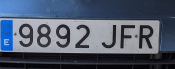

In [ ]:
#Función para obtener la imagen original con la matriícula segmentada
def imatge_segmentada(val):
           image = cv2.imread(val)
           #cv2_imshow(imutils.resize(image, width=440))
           newimage1 = imutils.resize(image, width=640)
           procesado, gray = procesamiento(image)
           #cv2_imshow(imutils.resize(procesado, width=440))
           x = segmentacion(procesado, newimage1, gray)
           return x

cv2_imshow(imatge_segmentada('9892JFR.jpg'))#6401JBX #9892JFR

#Segmentación de cada carácter


In [ ]:
#Función para tomar el contorno de cada dígito de izquierda a derecha
def buscar_contornos(contornos):
    i = 0
    boundings = [cv2.boundingRect(c) for c in contornos]
    (contornos, boundings) = zip(*sorted(zip(contornos, boundings),key=lambda b: b[1][i], reverse=False))
    return contornos

#Procesamos la imagen para encontrar los contornos
def proc_segm_letras(img_orig, kernel_size):
    gray = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY) #Gris 
    blur = cv2.GaussianBlur(gray,(1,1),0) #Difuminamos para suavizar el ruido y a la vez eliminar algunos bordes que no necesitamos 
    binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1] #Threshold para binarizar 

    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1)) 
    thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)

    rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size) 
    img_no_borders = reject_borders(thre_mor) #Quitamos los bordes 

    erosion = cv2.erode(img_no_borders,rectKernel,iterations = 1) #Hacemos erode
    return erosion

#Función para visualizar todos los carácteres segmentados
def visualitza_caracters(lista):
    fig = plt.figure(figsize=(10, 7))
    for i in range(len(lista)):
         fig.add_subplot(1, 7, i+1)
         plt.imshow(lista[i])

def segmenta_letras(img_orig, kernel_size):
    procesado = proc_segm_letras(img_orig,kernel_size) #Procesamos la imagen
    cont, _  = cv2.findContours(procesado, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #Encontramos contornos 
    l_caracteres=[] #Lista para guardar cada letra
    for c in buscar_contornos(cont):
        (x, y, w, h) = cv2.boundingRect(c)
        ratio = h/w  
         #Seleccionar contorno que cumpla las siguientes condiciones: 
        if 19<=h<=39 and 4<=w<=20 and  1<=ratio<=5.5:   #Altura entre 19 y 39, ratio entre 1 y 5.5.
               #cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2) # Dibujamos la bounding box en cada carácter (control de errores).
               letra_segmentada = img_orig[y+-2:y+h+2,x-2:x+w+2, ] #Imagen del carácter segmentado
               l_caracteres.append(letra_segmentada) #Lo añadimos a la lista de cada carácter

    #Controlamos si se nos ha colado la E azul de Europa que hay en todas las matrículas
    if len(l_caracteres)>7:
        del l_caracteres[0]

    #Si tenemos menos de 7 carácteres localizados significa que dos letras se nos han juntado y por eso el controno no ha cumplido los condiciones
    if len(l_caracteres)<7:
       segmenta_letras(img_orig,(1,3)) #Aumentamos el kernel_size del erosion para separar los carácteres
       return l_caracteres

    visualitza_caracters(l_caracteres) #Visualizamos todos los carácteres de la matrícula 
    return l_caracteres

#OCR con Pytesseract 

In [ ]:
#Función para procesar cada carácter con la inteción de facilitar el OCR
def procesar_caracter_OCR(img):
   f = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
   f = cv2.threshold(f, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]        
   f = cv2.dilate(f, np.ones((1,1),np.uint8), iterations = 1)
   f = cv2.erode(f, np.ones((1,1),np.uint8), iterations = 1)
   f = cv2.morphologyEx(f, cv2.MORPH_OPEN, np.ones((1,1),np.uint8))
   f = cv2.Canny(f, 100, 200)
   return f

In [ ]:
def OCR(letras):
  lista_caracteres = []
  """
  #Pruebas con cada carácter individual:
  custom_config = r'--oem 3 --psm 10 -c tessedit_char_whitelist=ABCDEFGHIJKLMÑOPQRSTUVWXYZ'
  pv = procesar_caracter_OCR(letras[4]) #Cuarto carácter
  letra = pytesseract.image_to_string(letras[4], config=custom_config)
  lista_caracteres.append(letra[0])
  """
           
  custom_config = r'--oem 3 --psm 10 -l osd -c tessedit_char_whitelist=0123456789'
  for i in letras[0:4]:
    procesado = procesar_caracter_OCR(i)
    letra = pytesseract.image_to_string(procesado, config=custom_config)
    lista_caracteres.append(letra[0])

  custom_config2 = r'--oem 3 --psm 10 -l osd -c tessedit_char_whitelist=ABCDEFGHIJKLMÑOPQRSTUVWXYZ' 
  for i in letras[4:7]:
      procesado = procesar_caracter_OCR(i)
      letra = pytesseract.image_to_string(i, config=custom_config2)
      lista_caracteres.append(letra[0])
  return lista_caracteres

In [ ]:
#os.chdir('./')     
!ls


0182GLK.jpg   1663FLN.jpg   3374KBF.jpg   5275HGY.jpg	7067KSH.jpg
0292LKY.jpg   2153GYX.jpg   3567DCX_.jpg  5416HML.jpg	7093HWB.jpg
0664JGR.jpg   2272HST.jpg   3587DCX_.jpg  5488LKV.jpg	7153JWD.jpg
0729HHG.jpg   2335KGY.jpg   3587DCX.jpg   5789JHB.jpg	7674LLX.jpg
0804FTB.jpg   2344KJP.jpg   3616LLF.jpg   5796DKP_.jpg	7982LCD.jpg
0907JRF.jpg   2377HSH.jpg   3660CRT.jpg   5796DKP.jpg	8611LGM.jpg
1062FNT_.jpg  2732LRG.jpg   3991KHB.jpg   5868GJV.jpg	8727JTC_.jpg
1062FNT.jpg   2929KXJ.jpg   4142HCF.jpg   5960CCW.jpg	8727JTC.jpg
1178HJS.jpg   3017FRG.jpg   4658JDG.jpg   6000GVT.jpg	9247CZG.jpg
1391KYW.jpg   3040JMB.jpg   4674FHC_.jpg  6401JBX.jpg	9296FJB.jpg
1498JBZ.jpg   3340JMF_.jpg  4674FHC.jpg   6554BNX.jpg	9892JFR.jpg
1565HTS.jpg   3340JMF.jpg   5275HGY_.jpg  6929LKK.jpg


In [ ]:
os.chdir('../BBDD Xavier Roca') 
from skimage.transform import resize

#Todo el proceso 
def Todo_proceso():
    total = 0
    for i,val in enumerate(os.listdir()[:1]):
           image = cv2.imread(val)
           newimage1 = imutils.resize(image, width=640)
           procesado, gray = procesamiento(image)
           x = segmentacion(procesado, newimage1, gray)
           kernel_size = (1,1)
           letras = segmenta_letras(x,kernel_size)
           images = []
    
Todo_proceso() 

In [ ]:
os.getcwd()

'/content/drive/MyDrive/BBDD Xavier Roca'

##CREATE DATA AUGMENTATION

In [ ]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot

def create_data_augmentation():
  for val in os.listdir():
    index_str = val.split('.')[0]
    img = load_img(val)
    # convert to numpy array
    data = img_to_array(img)
    # expand dimension to one sample
    samples = expand_dims(data, 0)
    # create image data augmentation generator
    datagen = ImageDataGenerator(brightness_range=[0.6,0.85], zoom_range=[0.9,1], rotation_range=20)
    # prepare iterator
    it = datagen.flow(samples, batch_size=1)

    for i in range(50):
      # generate batch of images
      batch = it.next()
      # convert to unsigned integers for viewing
      image = batch[0].astype('uint8')
      # plot raw pixel data
      img = cv2.resize(image, (10,25), interpolation = cv2.INTER_AREA)
      path_write = '../reals_dataAG/' + f'{index_str}_{i}.jpg'
      cv2.imwrite( path_write, img)

  return



In [ ]:
os.chdir('../NUMEROS/ORIGINAL/reals') 
create_data_augmentation()


In [ ]:
os.chdir('../../../LETRAS/ORIGINAL/reals') 
create_data_augmentation()


##CLASSIFIER NUMBERS

In [ ]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

In [ ]:
os.listdir('../')

['reals', 'reals_dataAG']

In [ ]:
os.chdir('../../../NUMEROS/ORIGINAL/reals_dataAG') 
labels=[]
images = []

for val in sorted(os.listdir()):
  if '.jpg' in val:
    image = plt.imread(val)
    images.append(image)
    labels.append(int(val.split('_')[0]))

In [ ]:
y = np.array(labels)
X = np.array(images, dtype=np.uint8) #convierto de lista a numpy

# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


Training data shape :  (400, 25, 10, 3) (400,)
Testing data shape :  (100, 25, 10, 3) (100,)


Text(0.5, 1.0, 'Ground Truth : 8')

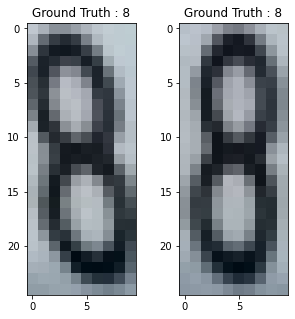

In [ ]:
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

In [ ]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

In [ ]:
import keras
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)
from keras.layers.advanced_activations import LeakyReLU
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 8
After conversion to one-hot: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [ ]:
import tensorflow as tf
#train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)
#declaramos variables con los parámetros de configuración de la red
INIT_LR = 1e-5 # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001
epochs = 100 # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento
batch_size = 1 # cantidad de imágenes que se toman a la vez en memoria
modelN = Sequential()

modelN.add(Conv2D(28, kernel_size=(3,3), input_shape=(25, 10, 3)))
modelN.add(MaxPooling2D(pool_size=(2, 2)))
modelN.add(Flatten()) # Flattening the 2D arrays for fully connected layers
modelN.add(Dense(128, activation=tf.nn.relu))
modelN.add(Dropout(0.2))
modelN.add(Dense(nClasses,activation=tf.nn.softmax))

In [ ]:
modelN.summary()
modelN.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

modelN.fit(train_X, train_Y, epochs=20)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 23, 8, 28)         784       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 4, 28)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1232)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               157824    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total params: 159,898
Trainable params: 159,898
Non-trainable params: 0
________________________________________________

In [ ]:
modelN.save("numbers_model.h5py")

INFO:tensorflow:Assets written to: numbers_model.h5py/assets


##CLASSIFIER LETERS

In [ ]:
os.listdir()

['5_0.jpg',
 '5_1.jpg',
 '5_2.jpg',
 '5_3.jpg',
 '5_4.jpg',
 '5_5.jpg',
 '5_6.jpg',
 '5_7.jpg',
 '5_8.jpg',
 '5_9.jpg',
 '5_10.jpg',
 '5_11.jpg',
 '5_12.jpg',
 '5_13.jpg',
 '5_14.jpg',
 '5_15.jpg',
 '5_16.jpg',
 '5_17.jpg',
 '5_18.jpg',
 '5_19.jpg',
 '5_20.jpg',
 '5_21.jpg',
 '5_22.jpg',
 '5_23.jpg',
 '5_24.jpg',
 '5_25.jpg',
 '5_26.jpg',
 '5_27.jpg',
 '5_28.jpg',
 '5_29.jpg',
 '5_30.jpg',
 '5_31.jpg',
 '5_32.jpg',
 '5_33.jpg',
 '5_34.jpg',
 '5_35.jpg',
 '5_36.jpg',
 '5_37.jpg',
 '5_38.jpg',
 '5_39.jpg',
 '5_40.jpg',
 '5_41.jpg',
 '5_42.jpg',
 '5_43.jpg',
 '5_44.jpg',
 '5_45.jpg',
 '5_46.jpg',
 '5_47.jpg',
 '5_48.jpg',
 '5_49.jpg',
 '0_0.jpg',
 '0_1.jpg',
 '0_2.jpg',
 '0_3.jpg',
 '0_4.jpg',
 '0_5.jpg',
 '0_6.jpg',
 '0_7.jpg',
 '0_8.jpg',
 '0_9.jpg',
 '0_10.jpg',
 '0_11.jpg',
 '0_12.jpg',
 '0_13.jpg',
 '0_14.jpg',
 '0_15.jpg',
 '0_16.jpg',
 '0_17.jpg',
 '0_18.jpg',
 '0_19.jpg',
 '0_20.jpg',
 '0_21.jpg',
 '0_22.jpg',
 '0_23.jpg',
 '0_24.jpg',
 '0_25.jpg',
 '0_26.jpg',
 '0_27.jpg',
 '0_28

In [ ]:
os.chdir('../../../LETRAS/ORIGINAL/reals_dataAG') 
labels = []
for val in sorted(os.listdir()):
  if '.jpg' in val:
    labels.append(val.split('_')[0])

l = list(set(labels))
dict_keys = {}
keys_inversed = {}
for i,val in enumerate(l):
  dict_keys[val] = i
  keys_inversed[i] = val
dict_keys

{'B': 6,
 'C': 7,
 'D': 16,
 'F': 14,
 'G': 8,
 'H': 1,
 'J': 5,
 'K': 18,
 'L': 13,
 'M': 12,
 'N': 11,
 'P': 2,
 'R': 19,
 'S': 4,
 'T': 0,
 'V': 3,
 'W': 15,
 'X': 10,
 'Y': 9,
 'Z': 17}

In [ ]:
#os.chdir('../../../LETRAS/ORIGINAL/reals_dataAG') 
labels=[]
images = []

for val in sorted(os.listdir()):
  if '.jpg' in val:
    image = plt.imread(val)
    images.append(image)
    labels.append(dict_keys[val.split('_')[0]])

y = np.array(labels)
X = np.array(images, dtype=np.uint8) #convierto de lista a numpy

# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)

train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

Total number of outputs :  20
Output classes :  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [ ]:
modelL = Sequential()

modelL.add(Conv2D(28, kernel_size=(3,3), input_shape=(25, 10, 3)))
modelL.add(MaxPooling2D(pool_size=(2, 2)))
modelL.add(Flatten()) # Flattening the 2D arrays for fully connected layers
modelL.add(Dense(128, activation=tf.nn.relu))
modelL.add(Dropout(0.2))
modelL.add(Dense(nClasses,activation=tf.nn.softmax))

In [ ]:
modelL.summary()
modelL.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

modelL.fit(train_X, train_Y, epochs=20)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 23, 8, 28)         784       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 4, 28)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1232)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               157824    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 20)                2580      
Total params: 161,188
Trainable params: 161,188
Non-trainable params: 0
________________________________________________

In [ ]:
modelL.save("leters_model.h5py")

INFO:tensorflow:Assets written to: leters_model.h5py/assets


##FINAL EXECUTION

In [ ]:
os.chdir('../../../BBDD Xavier Roca') 
from skimage.transform import resize

Original:  5796DKP
Predicted:  5796DKP
Original:  6554BNX
Predicted:  6554DNX
Original:  6401JBX
Predicted:  6401JBX
Original:  5789JHB
Predicted:  5789JHB
Original:  3567DCX
Predicted:  3587DCX
Original:  6000GVT
Predicted:  6000GVT
Original:  3040JMB
Predicted:  3044JMB
Original:  1498JBZ
Predicted:  6149DZ
Original:  0907JRF
Predicted:  0907JRF
Original:  2344KJP
Predicted:  2344KJP
Original:  0182GLK
Predicted:  0182GLK
Original:  6929LKK
Predicted:  6929LKK
Original:  3660CRT
Predicted:  3660CRT
Original:  1062FNT
Predicted:  1082FNT
Original:  3340JMF
Predicted:  3340JMF
Original:  9247CZG
Predicted:  9247CZG
Original:  3587DCX
Predicted:  3587DCX
Original:  5796DKP
Predicted:  5798DKP
Original:  1565HTS
Predicted:  1585HTS
Original:  7067KSH
Predicted:  7087KSH


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Original:  9892JFR
Predicted:  9892JFR
Original:  5488LKV
Predicted:  5488LKV
Original:  7153JWD
Predicted:  7153JWD
Original:  2929KXJ
Predicted:  2929KXJ
Original:  2153GYX
Predicted:  2153GYX
Original:  4674FHC
Predicted:  4874FHC
Original:  5275HGY
Predicted:  5275HGY
Original:  5275HGY
Predicted:  5275HGY
Original:  8727JTC
Predicted:  8727JTC
Original:  4674FHC
Predicted:  4874FHC
Original:  8727JTC
Predicted:  8727JTC
Original:  3587DCX
Predicted:  3567DCX
Original:  0729HHG
Predicted:  0729HHG
Original:  3340JMF
Predicted:  3340JMF
Original:  0292LKY
Predicted:  0292LKY
Original:  4658JDG
Predicted:  4668JDG
Original:  7982LCD
Predicted:  7982LCD
Original:  1062FNT
Predicted:  1062FHT
Original:  4142HCF
Predicted:  4142HCF
Original:  8611LGM
Predicted:  8611LGM
Original:  1391KYW
Predicted:  1391KYW
Original:  3991KHB
Predicted:  3991KHD
Original:  3017FRG
Predicted:  3017FRG
Original:  2732LRG
Predicted:  2732LRG
Original:  5416HML
Predicted:  5416HML
Original:  7674LLX
Predic

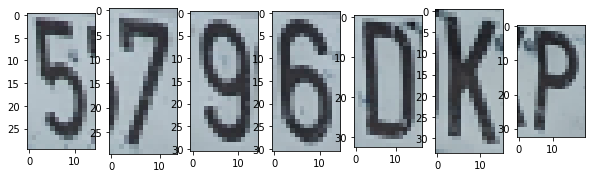

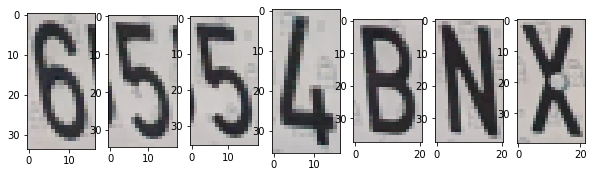

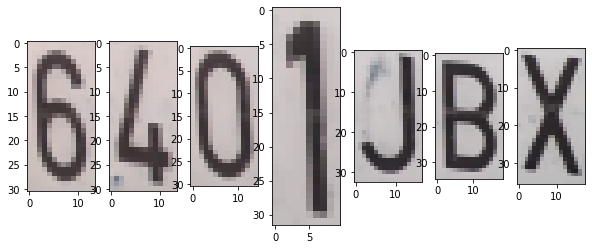

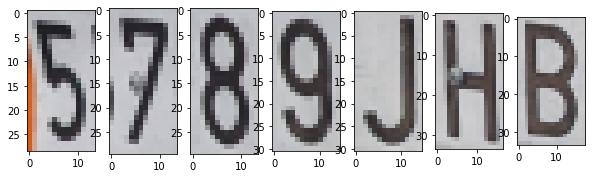

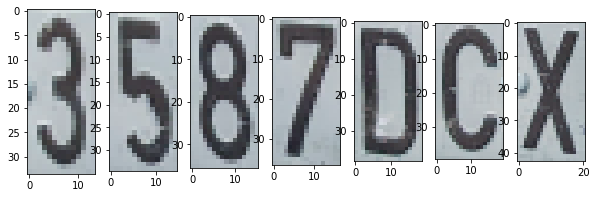

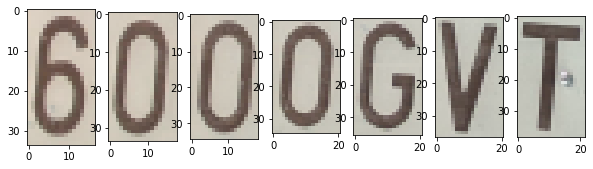

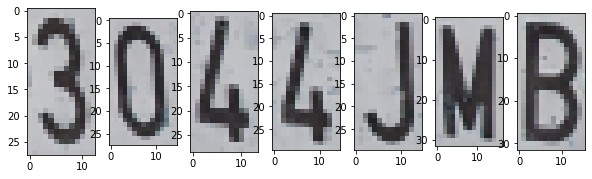

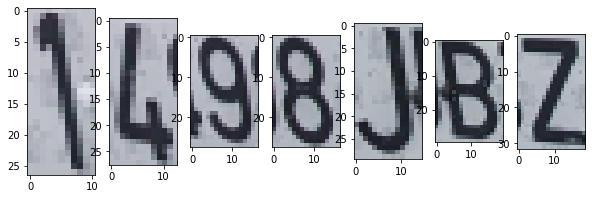

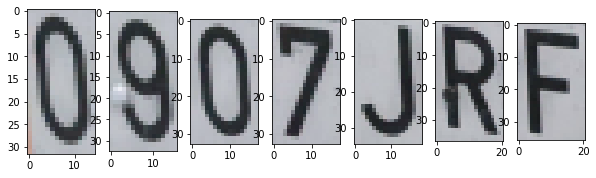

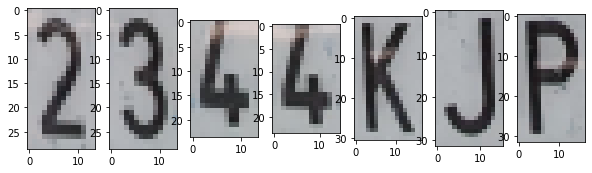

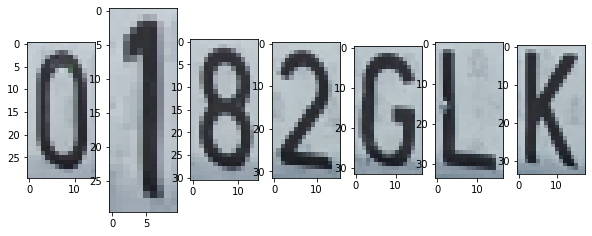

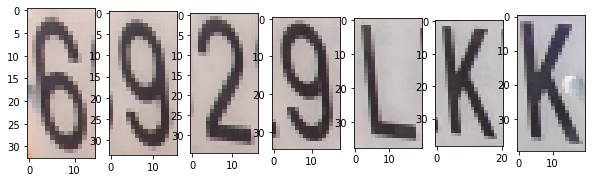

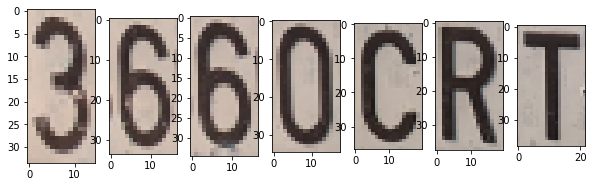

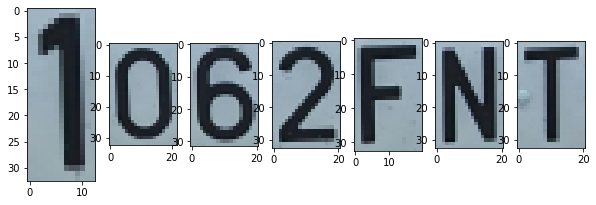

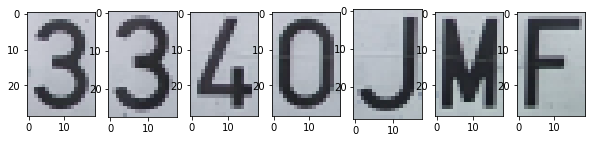

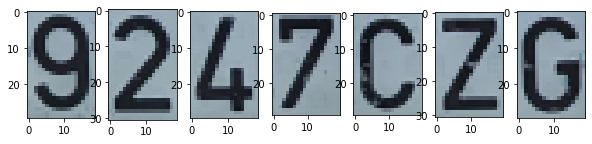

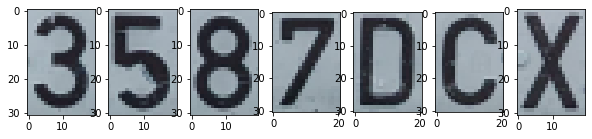

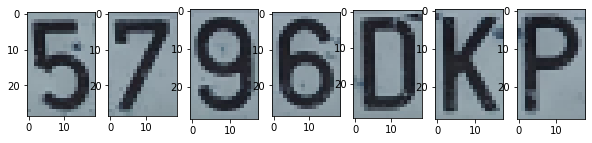

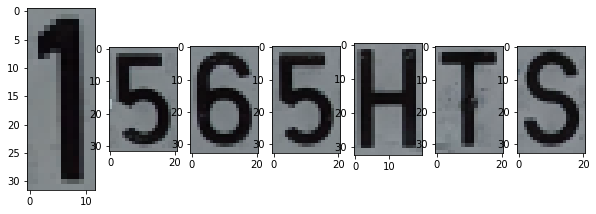

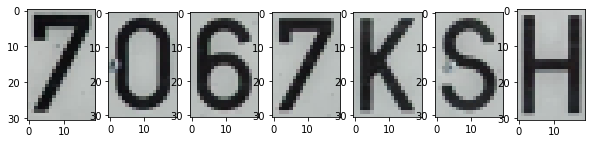

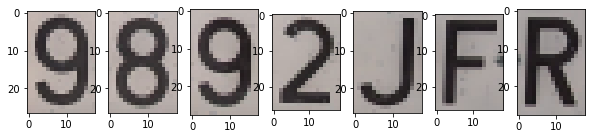

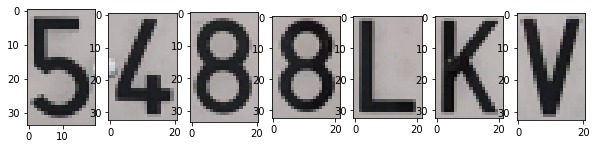

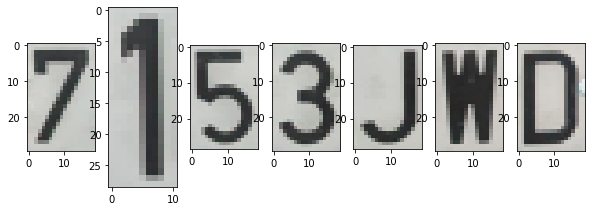

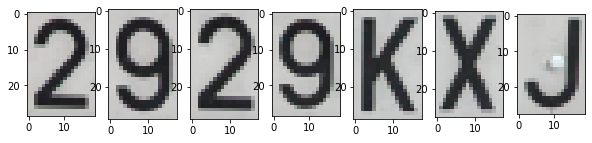

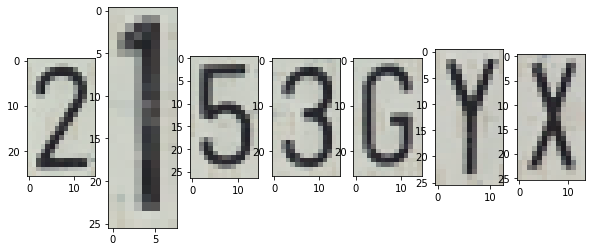

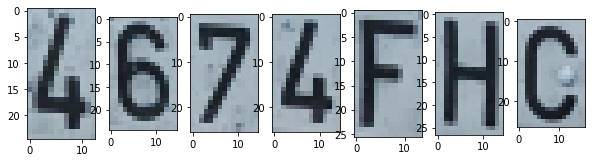

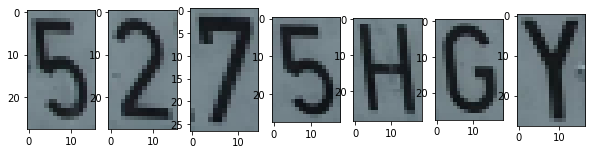

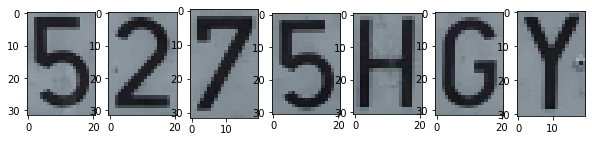

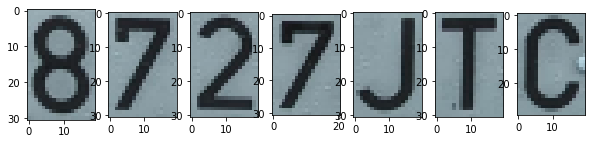

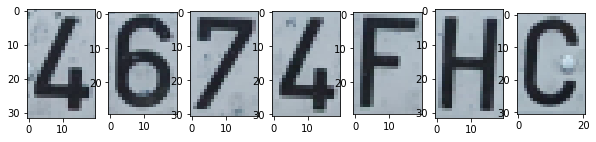

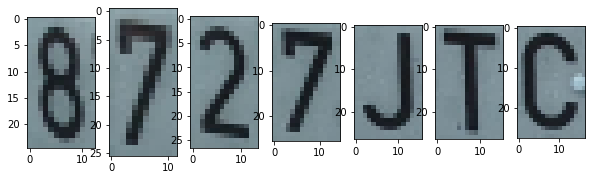

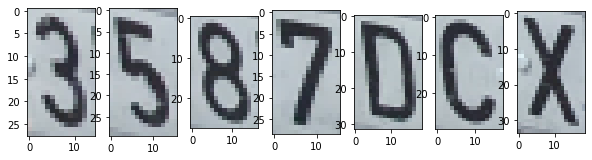

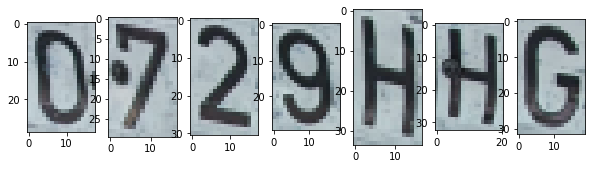

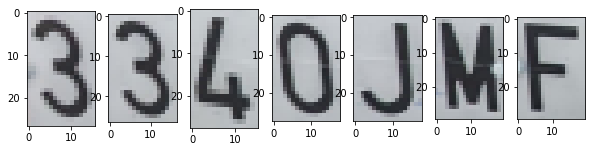

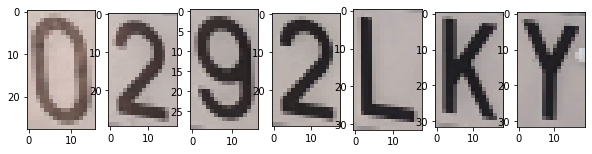

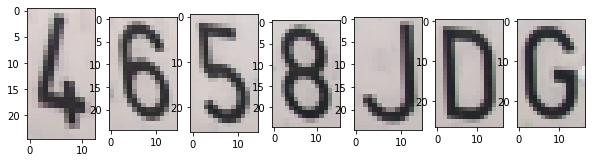

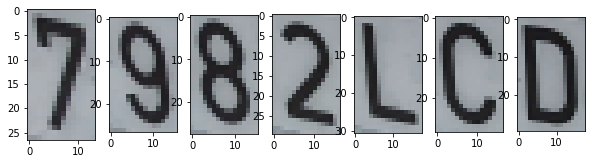

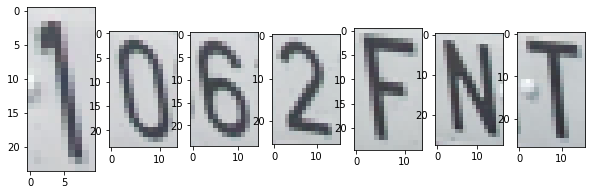

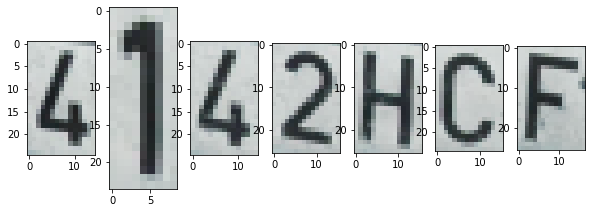

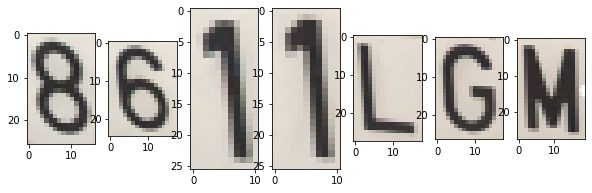

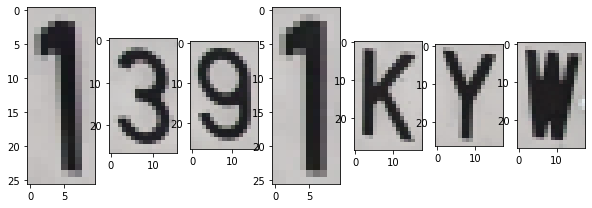

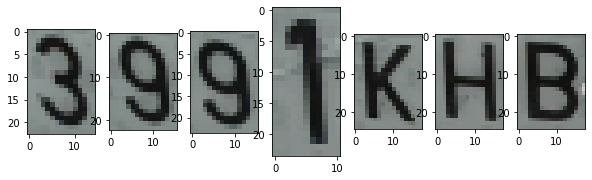

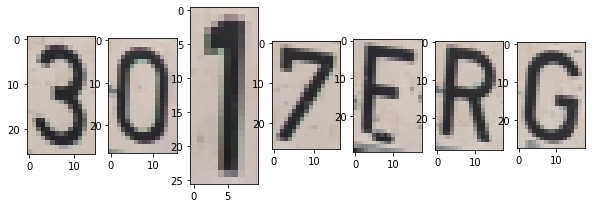

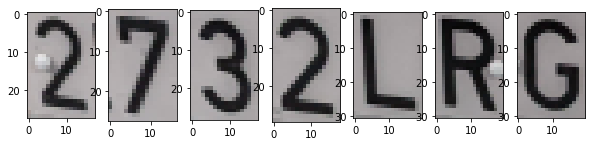

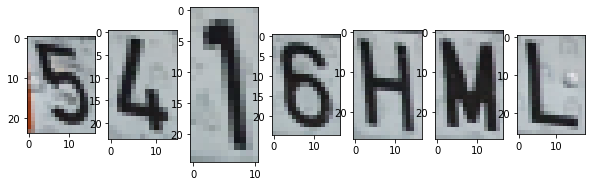

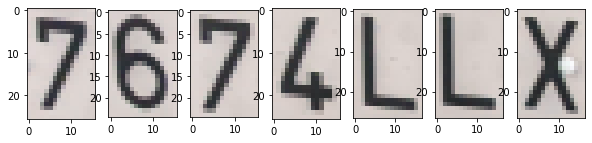

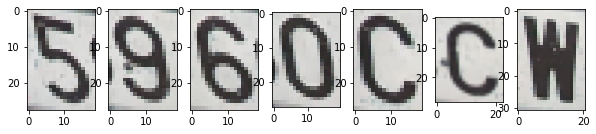

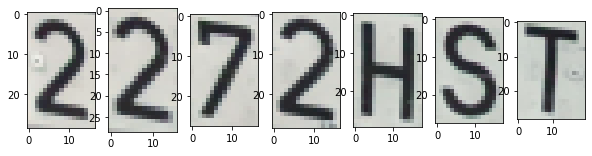

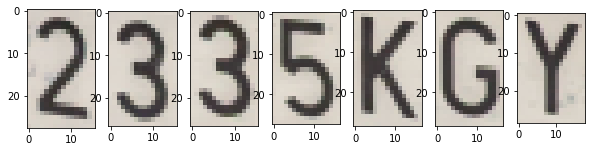

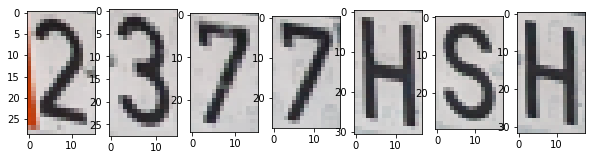

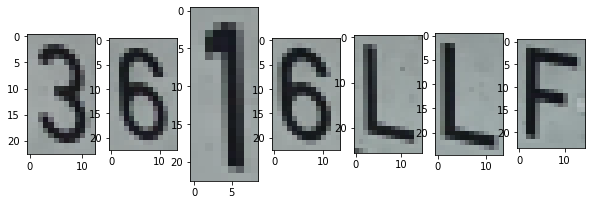

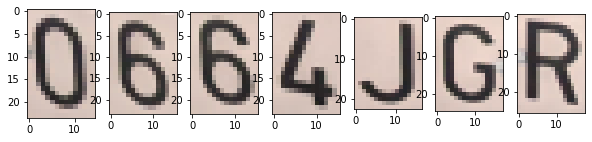

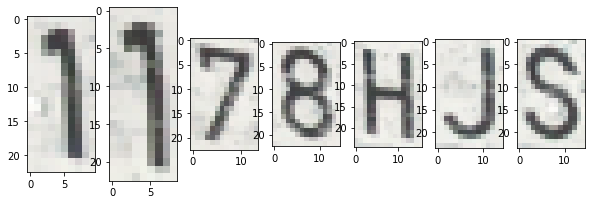

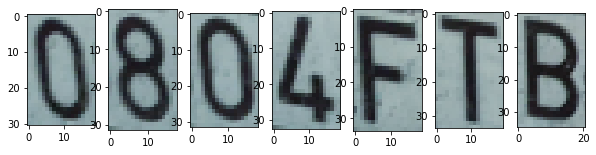

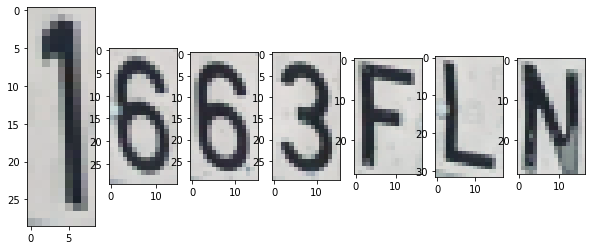

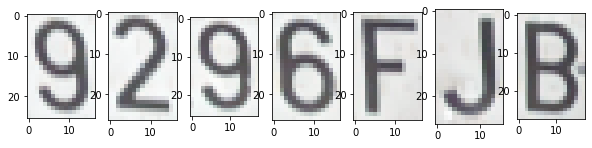

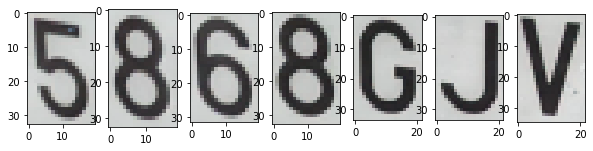

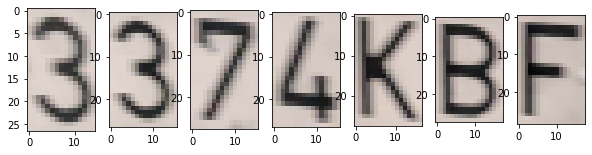

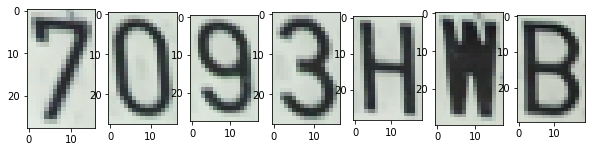

In [ ]:


#Todo el proceso 
def Todo_proceso():
    totals = [0]*8
    y_true = []
    y_pred = []
    for i,val in enumerate(os.listdir()):
           image = cv2.imread(val)
           newimage1 = imutils.resize(image, width=640)
           procesado, gray = procesamiento(image)
           x = segmentacion(procesado, newimage1, gray)
           kernel_size = (1,1)
           letras = segmenta_letras(x,kernel_size)
           images = []
           
           for x in letras:
              image_resized = resize(x, (25,10),anti_aliasing=True,clip=False,preserve_range=True)
              #cv2_imshow(x)
              images.append(image_resized)

           XN = np.array(images[:4], dtype=np.uint8) #convierto de lista a numpy
           test_XN = XN.astype('float32')
           test_XN = test_XN / 255.

           XL = np.array(images[4:], dtype=np.uint8) #convierto de lista a numpy
           test_XL = XL.astype('float32')
           test_XL = test_XL / 255.

           pred_name = ''
           predicted_classes = modelN.predict(test_XN)
           for i, img_tagged in enumerate(predicted_classes):
             pred_name += str(img_tagged.tolist().index(max(img_tagged))) 
          
           predicted_classesL = modelL.predict(test_XL)
           for i, img_tagged in enumerate(predicted_classesL): 
            pred_name += str(keys_inversed[img_tagged.tolist().index(max(img_tagged))]) 

           true_label = val.split('.')[0]
           if '_' in true_label:
             true_label = true_label[:-1]
           print('Original: ',true_label)
           print('Predicted: ',pred_name)
           points = 0
           for x,xx in zip(true_label, pred_name):
             y_true.append(x)
             y_pred.append(xx)
             if x == xx:
               points +=1
           totals[points] += 1
    return np.array(totals)/len(os.listdir()), y_true, y_pred
values, y_true, y_pred = Todo_proceso() 


In [ ]:
b = set(y_true)
[x for x in y_true if x not in b]

[]

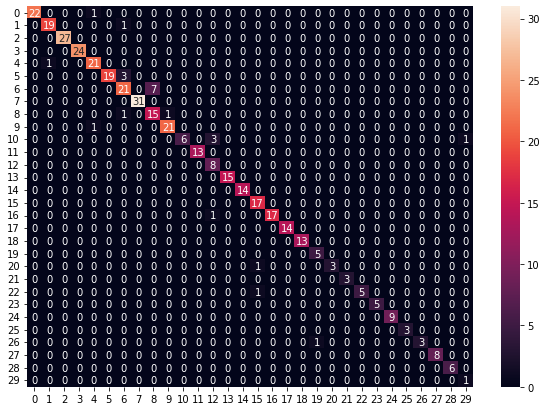

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(array)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

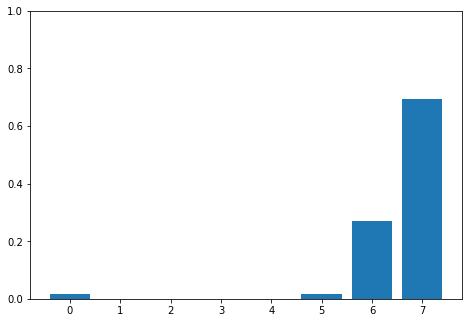

In [ ]:

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = [x for x in range(8)]
ax.bar(langs,values )
plt.ylim((0,1))
plt.show()

1.0